In [ ]:
!pip install -q sentence-transformers faiss-cpu transformers accelerate datasets sentencepiece scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 116.2 MB/s eta 0:00:00


In [ ]:
import json, os

chunks_path = "/content/bangla_biology_chunks.json"
questions_path = "/content/bangla_bio_questions.json"

with open(chunks_path, "r", encoding="utf-8") as f:
    chunks = json.load(f)

with open(questions_path, "r", encoding="utf-8") as f:
    questions = json.load(f)

print("Chunks:", len(chunks))
print("Questions:", len(questions))
print("Sample chunk:", chunks[0]["text"][:200])
print("Sample question:", questions[0]["question"])


Chunks: 159
Questions: 120
Sample chunk: রক্ত হলো এক ধরনের যোগ কলা। মানুষ ও অন্যান্য মেরুদণ্ডী প্রাণীর সংবহন তন্ত্রের একটি দৈহিক তরল যা কোষে প্রয়োজনীয় পদার্থসমূহ যেমন পুষ্টিদায়ক পদার্থ ও অক্সিজেন সরবরাহ করে এবং কোষ থেকে বিপাকীয় রেচন পদার
Sample question: রক্ত কী ধরনের কলা?


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss, numpy as np, pickle

embedder = SentenceTransformer("sentence-transformers/LaBSE")

texts = [c["text"] for c in chunks]
embeddings = embedder.encode(texts, convert_to_numpy=True, batch_size=32, show_progress_bar=True)

faiss.normalize_L2(embeddings)
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)

faiss.write_index(index, "/content/bangla_bio.index")
with open("/content/bangla_chunks.pkl","wb") as f:
    pickle.dump(chunks, f)

print("FAISS index built:", index.ntotal)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

FAISS index built: 159


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "bigscience/bloomz-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Model loaded on:", device)


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

Model loaded on: cuda


In [ ]:
import re, numpy as np, faiss, pickle

index = faiss.read_index("/content/bangla_bio.index")
with open("/content/bangla_chunks.pkl","rb") as f:
    chunks_meta = pickle.load(f)

def split_sentences(text):
    return re.split(r'[।!?]\s*', text)

def retrieve_top_sentences(question, k_chunks=3, k_sent=3):
    q_emb = embedder.encode([question], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    _, I = index.search(q_emb, k_chunks)

    sentences = []
    for idx in I[0]:
        for s in split_sentences(chunks_meta[idx]["text"]):
            if len(s.strip()) > 20:
                sentences.append(s.strip())

    if not sentences:
        return []

    sent_emb = embedder.encode(sentences, convert_to_numpy=True)
    faiss.normalize_L2(sent_emb)
    sims = sent_emb @ q_emb.T
    top_ids = np.argsort(sims.squeeze())[::-1][:k_sent]

    return [sentences[i] for i in top_ids]


In [ ]:
def build_rag_prompt(question, sentences):
    context = "\n".join([f"- {s}" for s in sentences])

    prompt = f"""
আপনি একজন জীববিজ্ঞান শিক্ষক।

নিয়ম:
- সর্বোচ্চ ১–২টি বাক্য লিখবেন
- শুধুমাত্র দেওয়া তথ্য ব্যবহার করবেন
- অতিরিক্ত ব্যাখ্যা করবেন না
- তথ্য না থাকলে লিখবেন: "উত্তর দেওয়া সম্ভব নয়"

তথ্য:
{context}

প্রশ্ন: {question}

উত্তর (১–২ বাক্য):
""".strip()
    return prompt

def generate_answer(prompt, max_new_tokens=60):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=768).to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        repetition_penalty=1.2,
        length_penalty=0.8
    )
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text.split("উত্তর",1)[-1].strip()


In [ ]:
import tqdm, json, pandas as pd

results = []

for q in tqdm.tqdm(questions):
    qtext = q["question"]
    gold = q["gold_answer"]

    # Baseline
    baseline_prompt = f"প্রশ্ন: {qtext}\nসংক্ষিপ্ত উত্তর দিন:"
    baseline_ans = generate_answer(baseline_prompt)

    # RAG
    retrieved = retrieve_top_sentences(qtext)
    rag_prompt = build_rag_prompt(qtext, retrieved)
    rag_ans = generate_answer(rag_prompt)

    results.append({
        "id": q["id"],
        "question": qtext,
        "gold": gold,
        "baseline_ans": baseline_ans,
        "rag_ans": rag_ans,
        "retrieved_sentences": retrieved
    })

with open("/content/bangla_actual_rag_results.json","w",encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

pd.DataFrame(results).to_csv("/content/bangla_actual_rag_results.csv", index=False)
print("Saved results.")


100%|██████████| 120/120 [01:23<00:00,  1.43it/s]

Saved results.


In [ ]:
import re, statistics
from sklearn.metrics.pairwise import cosine_similarity

def norm(s):
    return re.sub(r'[^\w\s]', '', s.lower())

def token_f1(p, g):
    p, g = norm(p).split(), norm(g).split()
    if not p or not g: return 0
    c = set(p) & set(g)
    if not c: return 0
    pr = len(c)/len(p)
    re_ = len(c)/len(g)
    return 2*pr*re_/(pr+re_)

bf1, rf1, bsim, rsim = [], [], [], []
bh, rh = 0, 0

for r in results:
    bf1.append(token_f1(r["baseline_ans"], r["gold"]))
    rf1.append(token_f1(r["rag_ans"], r["gold"]))

    eg = embedder.encode([r["gold"]])
    eb = embedder.encode([r["baseline_ans"]])
    er = embedder.encode([r["rag_ans"]])

    bsim.append(float(cosine_similarity(eg, eb)[0][0]))
    rsim.append(float(cosine_similarity(eg, er)[0][0]))

    ctx = norm(" ".join(r["retrieved_sentences"]) + " " + r["gold"])
    def hallu(ans):
        t = norm(ans).split()
        if not t: return False
        return sum(1 for x in t if x not in ctx)/len(t) > 0.3

    if hallu(r["baseline_ans"]): bh += 1
    if hallu(r["rag_ans"]): rh += 1

print("Baseline F1:", round(statistics.mean(bf1),4))
print("RAG F1:", round(statistics.mean(rf1),4))
print("Baseline semantic:", round(statistics.mean(bsim),4))
print("RAG semantic:", round(statistics.mean(rsim),4))
print("Baseline hallucinations:", bh)
print("RAG hallucinations:", rh)


Baseline F1: 0.0381
RAG F1: 0.2277
Baseline semantic: 0.2891
RAG semantic: 0.5902
Baseline hallucinations: 107
RAG hallucinations: 1


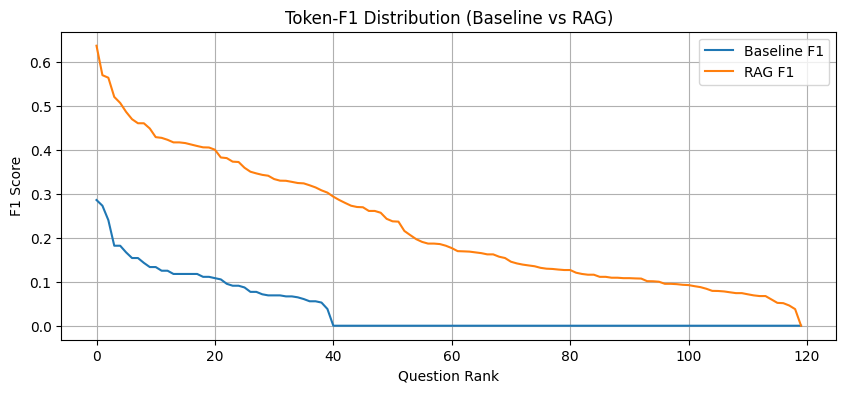

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,4))
plt.plot(sorted(bf1, reverse=True), label="Baseline F1")
plt.plot(sorted(rf1, reverse=True), label="RAG F1")
plt.title("Token-F1 Distribution (Baseline vs RAG)")
plt.xlabel("Question Rank")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()
